[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab10_diffusion.ipynb)

# Deep Learning Part 8: Denoising Diffusion Probabilistic Models (DDPM)

## Description

In this section, we train an image generation model using diffusion. Diffusion is just one of several techniques to generate images, but it has recently surpassed the GAN as the state-of-the-art generation model.

The diffusion model is trained to remove noise from images, and once it is fully trained it can take random noise and fully "denoise" it into an image that looks reasonably like the training set.

## Objectives
- Implement forward process of diffusion
- Implement backward process of diffusion
- Generate images with the diffusion process
- Answer questions about diffusion

### Helpful Reading
- Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
- Improved Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2102.09672



In [1]:
from abc import abstractmethod
import math
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, Resize, Lambda, ToTensor

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Hyperparameters
MAX_TIMESTEPS = 1000
image_size = 32
lr = .0001

We have given you a simpler version of the UNet used in "Improved Denoising Diffusion Probabilistic Models." Feel free to familiarize yourself with the model. It is similar to the UNet we made in the cancer detection lab, but has layers that incorporate the timestep embedding. The model is already fully implemented.

In [3]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module


def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


# Note: this is an abstract method, do not implement `forward`
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels

        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1)
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_channels, self.out_channels)
        )
        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h


class UNetModel(nn.Module):
    """
    The full UNet model with timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    """

    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_res_blocks,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = hidden_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.channel_mult = channel_mult

        time_embed_dim = hidden_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, hidden_channels, 3, padding=1))
        ])
        input_block_chans = [hidden_channels]
        ch = hidden_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * hidden_channels)]
                ch = mult * hidden_channels
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch)))
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout),
            ResBlock(ch, time_embed_dim, dropout),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=hidden_channels * mult,
                    )
                ]
                ch = hidden_channels * mult
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm(32, ch),
            nn.SiLU(),
            zero_module(nn.Conv2d(hidden_channels, out_channels, 3, padding=1))
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.

        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x H x W] Tensor of outputs.
        """

        xs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        for module in self.input_blocks:
            x = module(x, emb)
            xs.append(x)
        x = self.middle_block(x, emb)
        for module in self.output_blocks:
            cat_in = torch.cat([x, xs.pop()], dim=1)
            x = module(cat_in, emb)
        return self.out(x)


# Part 1: Implement a linear and cosine scheduler

A scheduler is an important aspect to training a diffusion model. The scheduler returns a sequence of $\beta$ values, i.e. $[\beta_1, \cdots, \beta_T]$, that help determine how much noise is added to an image for training (forward process) and is removed from an image for inference (backward process). While the linear and cosine beta schedulers are valid ways of computing $\beta$s, the cosine scheduler is a better choice. Both schedulers should return 1-D tensors containing $[\beta_1, \cdots, \beta_T]$.

While we will only use t=1...T in training, we will need $\bar{\alpha}_0=1$ in the sampling function. To ensure $\bar{\alpha}_0 = 1$, you should prepend your list of $\beta$ with $\beta_0 = 0$. This will also ensure your indices match up with PyTorch's 0-indexed tensors.

**Tip:** Implement and use the linear beta scheduler first while you debug your diffusion model. Once you know your model works, then you can switch to the cosine scheduler for better results.

In [4]:
def linear_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] linearly. Discussed in "Denoising Diffusion Probabilistic Models"
    Example values for β1, βT shown in 1st bullet point of Appendix B.
    """
    t0 = 1e-4
    t1 = 0.02
    schedule = np.concatenate([np.array([0]), np.linspace(t0, t1, timesteps)])
    return schedule

def cosine_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] using eq. 17 of "Improved Denoising Diffusion Probabilistic Models"
    """
    # Initialize s and get the ranging t values
    s = .008
    t_vals = np.arange(timesteps+1) / timesteps + s

    # calcualte f(t) and f(0)
    cos_squared = np.cos(t_vals * np.pi * 0.5 / (1 + s)) ** 2
    f0 = np.cos(s/(1+s)*np.pi / 2)**2

    # Get alpha and find the ratio, return the clipped values
    a_t = cos_squared / f0
    ratio = a_t[1:] / a_t[:-1]

    # append a 0 at the beginning of ratio
    ratio = np.concatenate([np.array([1]), ratio])
    return np.clip(1 - ratio, a_min=0, a_max=.999)

# print(linear_beta_schedule(MAX_TIMESTEPS))
# print(cosine_beta_schedule(MAX_TIMESTEPS))

It would be helpful to compute global variables for $\beta$, $\alpha$, and $\bar{\alpha}$ down below so you don't need to recompute them for the forward and backward process. $\alpha$ and $\bar{\alpha}$ are defined right above equation 4 in "Denoising Diffusion Probability Models."

Note that the cosine schedule uses $\bar{\alpha}$ to compute $\beta$. But since we clip $\beta$ after deriving it, you should recompute $\bar{\alpha}$ from $\alpha$ and the clipped $\beta$.

In [5]:
def compute_alpha(beta):
    return 1 - beta

def compute_alpha_bar(alpha):
    return np.cumprod(alpha)

Compute values for both schedulers.

In [6]:
lin_alpha = compute_alpha(linear_beta_schedule(MAX_TIMESTEPS))
lin_alpha_bar = compute_alpha_bar(lin_alpha)

cos_alpha = compute_alpha(cosine_beta_schedule(MAX_TIMESTEPS))
cos_alpha_bar = compute_alpha_bar(cos_alpha)

Figure 5 of "Improved Denoising Diffusion Probabilistic Models" graphs the $\bar{\alpha}$ schedule. Graph both your $\bar{\alpha}$ schedulers to verify your schedulers are correct.

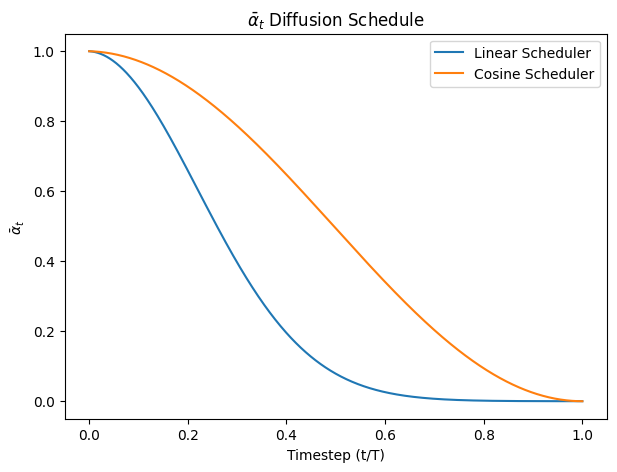

In [7]:
# Get the x values
x_values = np.arange(MAX_TIMESTEPS+1) / MAX_TIMESTEPS

# Set up the figure
plt.figure(figsize=(7, 5))
plt.title(r'$\bar{\alpha}_t$ Diffusion Schedule')
plt.xlabel(r'Timestep (t/T)')
plt.ylabel(r'$\bar{\alpha}_t$')

# Plot the figure, add a legend, and show it
plt.plot(x_values, lin_alpha_bar, label = 'Linear Scheduler')
plt.plot(x_values, cos_alpha_bar, label = 'Cosine Scheduler')
plt.legend()
plt.show()

Select which scheduler to use. To prevent broadcasting images, reshape all three lists to (T, 1, 1, 1). Put the tensors on the device, and if you used NumPy to create the tensors, convert from double to floats.

In [8]:
def select_scheduler(timesteps = MAX_TIMESTEPS, use_linear = True, device = device):
    # If it is linear, calculate the linear alpha schedule, otherwise cosine schedule
    if use_linear:
        alpha_schedule = compute_alpha(linear_beta_schedule(MAX_TIMESTEPS))
    else:
        alpha_schedule = compute_alpha(cosine_beta_schedule(MAX_TIMESTEPS))

    # Get the alpha bar
    alpha_bar = compute_alpha_bar(alpha_schedule)

    # Reshape the lists to (T,1,1,1), convert the double to floats, and put it on the device
    alpha_bar = torch.from_numpy(alpha_bar.reshape(-1,1,1,1)).float().to(device)
    alpha_schedule = torch.from_numpy(alpha_schedule.reshape(-1,1,1,1)).float().to(device)
    return alpha_bar, alpha_schedule


use_linear = True
alpha_bar,alpha_schedule = select_scheduler(use_linear = use_linear)

# Part 2: Implement the forward diffusion (training) process

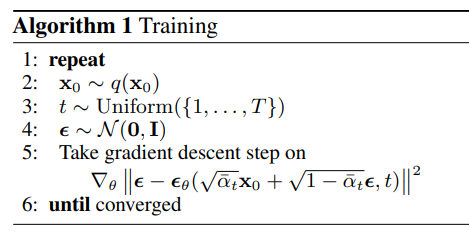

While you might be accustomed to pseudocode, deep learning pseudocode can sometimes be difficult to parse in the beginning and so we will explain all the steps here. The first thing to note is that **there is an implicit batch dimension included in the pseudocode**, so do not interpret this training loop as operating on a single image.

Line 2: Sample a batch of images $x_0$ from you dataset of images $q$. The subscript $0$ denotes the current timestep $t$, i.e. $x_{t=0} \equiv x_0$.

Line 3: Sample from the uniform distribution a batch of timesteps between 1 and $T$. The timesteps in the batch do not need to match.

Line 4: Sample noise from the normal distribution. In line 5 we see that the noise is going to be subtracted and multiplied element-wise to our batch of images. This means that the shape of the noise needs to match the shape of the batch of images, i.e. noise.shape = images.shape = (B, C, H, W).

Line 5: There is an implicit $x_t$ being created here where $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$. Therefore, $x_t$ and $t$ are passed into our diffusion model $\epsilon_{\theta}$. The model's goal is to predict the noise $\epsilon$ that was added into the model. $\lVert \epsilon - \epsilon_{\theta}(x_t, t) \rVert^2$ is our loss and it means to take the mean squared error between $\epsilon$ and our model's prediction of $\epsilon$. The final two parts of line 5 are $\nabla_{\theta}$ and "take the gradient descent step" which translates into pytorch as call `loss.backward()` and `optimizer.step()` respectively.

Lines 1 and 6 mean to continually train your model until there is no improvement.

In [9]:
def training(model, optimizer, dataloader, n_minibatches=1500, T = MAX_TIMESTEPS, use_linear = True):
    # Put the model in training mode, initialize the training loss, get the alpha scheduler, and set up the loop
    model.train()
    training_loss = []
    alpha_bar, alpha_schedule = select_scheduler(use_linear = use_linear, device = device)
    loop = tqdm(total=n_minibatches, position=0, leave=True)

    # loop through our dataloader, get our images, time, and noise
    for i in range(n_minibatches):
        x0,y0 = next(iter(dataloader))
        x0,y0 = x0.to(device), y0.to(device)
        t = torch.randint(1, T + 1, (x0.shape[0],)).to(device)
        noise = torch.randn_like(x0).to(device)

        # get alpha_bar_t and calculate x_t
        alpha_bar_t = alpha_bar[t]
        x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise

        # get the forward prediction and calculate the loss
        noise_hat = model(x_t, t)
        loss = torch.nn.functional.mse_loss(noise, noise_hat)

        # take the gradient descent step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append the loss to our training_loss
        training_loss.append(loss.item())

        # update our loop
        loop.set_description('Training: Iteration:{}/{}, Loss:{:.4f}'.format(i+1, n_minibatches, training_loss[-1]))
        loop.update()

    # Return our loss list
    loop.close()
    return training_loss

# Part 3: Implement the backward diffusion (sampling) process

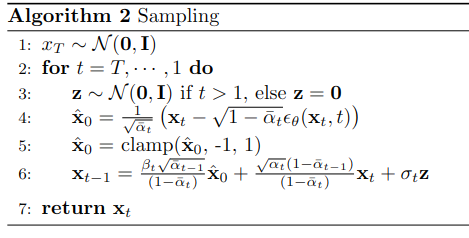

where $\bar{\alpha}_0 = 1$ and $\sigma_t = \sqrt{\beta_t}$.

**Note:** the only time $\alpha_t$ (without bar) is used instead of $\bar{\alpha}_t$ (with bar) is under the square root in the second term on line 6 (the numerator multiplied by $x_t$). If you mix up $\alpha$ and $\bar{\alpha}$, your sampling will not work!

In [22]:
@torch.no_grad()
def sampling(model, batch_size, T = MAX_TIMESTEPS, device=device, use_linear=True):
    # put our model in eval mode, get the noise images, our timesteps, and our alpha bar
    model.eval()
    x_T = torch.randn((batch_size, 1, image_size, image_size)).to(device)
    t_steps = torch.arange(T, 0, -1).to(device)
    alpha_bar, alpha_schedule = select_scheduler(use_linear=use_linear)

    # Get beta and sigma, and initialize our loop
    beta = 1 - alpha_schedule
    sigma = torch.sqrt(beta)
    loop = tqdm(total=T, position=0, leave=True)

    # Loop through our time steps, get our t tensore and get z
    for t in t_steps:
        t_tensor = torch.ones(batch_size).int().to(device) * t
        if t >1:
            z = torch.randn_like(x_T)
        else:
            z = torch.zeros_like(x_T)

        # Handle coefficient time variables
        if t == 1:
            a_bar_m1 = 1
        else:
            a_bar_m1 = alpha_bar[t_tensor-1]

        # Calculate all other scheduled variables
        a_bar = alpha_bar[t_tensor]
        a_bar_m1 = alpha_bar[t_tensor-1]
        a_t = alpha_schedule[t_tensor]
        b_t = beta[t_tensor]
        sigma_t = sigma[t_tensor]

        # Get the predicted x0
        noise_hat = model(x_T, t_tensor)
        x0_hat = 1 / torch.sqrt(a_bar) * (x_T - torch.sqrt(1-a_bar) * noise_hat)
        x0_hat = torch.clamp(x0_hat, -1, 1)

        # Get the next iteration
        c_1 = b_t * torch.sqrt(a_bar_m1) / (1 - a_bar)
        c_2 = torch.sqrt(a_t) * (1 - a_bar_m1) / (1 - a_bar)
        x_T = c_1 * x0_hat + c_2 * x_T + sigma_t * z

        # Update the loop
        loop.set_description(f'Generating {batch_size} Images:')
        loop.update()

    # Close the loop and return our images
    loop.close()
    return x_T

    # Implement Algorithm 2 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"

    # return generated image

# Part 4: Train and generate images

In [11]:
preprocess_transform = Compose([
    Resize(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])

In [14]:
model = UNetModel(
        in_channels=1,
        hidden_channels=32,
        out_channels=1,
        num_res_blocks=2,
        dropout=0.,
        channel_mult=(1, 2, 2, 2),
    ).to(device)

batch_size = 24
dataset = torchvision.datasets.MNIST("data/", train=True, download=True, transform=preprocess_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=lr)

In [15]:
train_losses = training(model, optimizer, dataloader, use_linear=False)

Training: Iteration:1500/1500, Loss:0.0407: 100%|██████████| 1500/1500 [01:35<00:00, 15.77it/s]


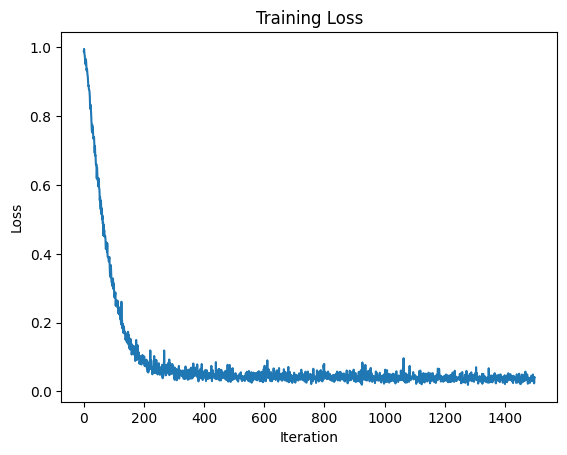

In [16]:
# plot your training loss
plt.title("Training Loss")
plt.plot(train_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [31]:
# Use sampling() to generate 16 images and plot them below
images = sampling(model,16, use_linear=False, device = device)

Generating 16 Images:: 100%|██████████| 1000/1000 [00:20<00:00, 48.56it/s]


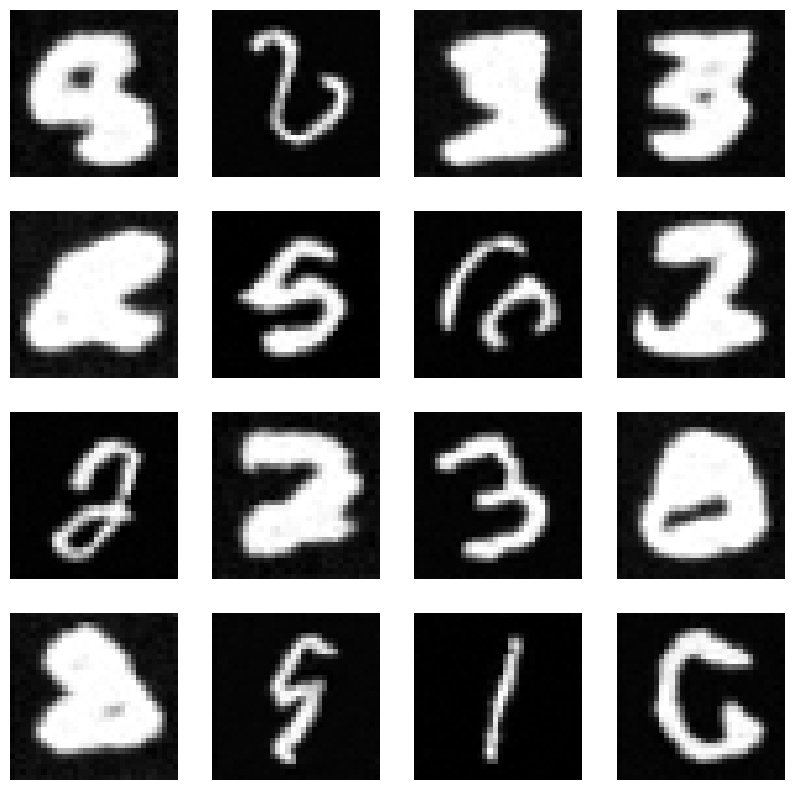

In [32]:
# plot the images in a 4 by 4 subplot
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i].squeeze().cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

# Part 5: Questions

1. Where do we scale the values of our training data? What range do we scale the data to? Why do we scale the data in that range?

2. Why is the cosine scheduler better than the linear scheduler?

3. In the forward step, we perform a random number of denoising steps in one forward pass, but in the backward process, we have to perform T forward passes to generate images. Why is that?

4. What is our network learning to predict?

5. If we wanted to perform conditional generation; for example, if we wanted to provide our network with a digit and have it produce an image of that digit, what would we have to change?

1. We scale pixel values in the 'preprocess_transform' function to a range of [−1,1]. This normalization makes sure that the data distribution aligns well with the activation functions in the network, improving training stability and performance.

2. The cosine scheduler is better than the linear scheduler because it allocates more training focus on less noisy images by adjusting the noise levels non-linearly. This helps the model learn finer details more effectively, leading to improved sample quality compared to the linear scheduler.

3. During training, we randomly choose a timestep to simulate random denoising, allowing for many different stages in the forward step. In the generation process, we must iteratively remove noise step by step from the highest noise level 𝑇 down to zero, requiring 𝑇 forward passes to make our image.

4. Our network learns to predict the aded noise at each timestep during the noising process. By accurately estimating this noise, the model can effectively subtract it to reconstruct the original image from noisy inputs.

5. To perform conditional generation, we would modify the network to accept additional input representing the condition, such as the digit label. This could involve incorporating the condition into the model's architecture or input, and training the network with data that pairs conditions with corresponding images so it learns to generate images based on the provided condition.